# Load Data

In [1]:
import tensorflow as tf

# Load the Fashion MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

2025-01-31 11:36:27.914153: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 11:36:28.032290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738348588.094334   14388 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738348588.118848   14388 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 11:36:28.248435: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Data Prep

In [2]:
import numpy as np

# Subset your data the same 3 digit classes you used in the Random Forest problem from the last assignment.

# Again, You can totally copy any code over from the fmnist_examples notebook and modify it.
# You can use chatGPT, copilot, google, or other AI or online resources.
# Use each other, the goal is to complete the objectives and maybe learn something new, not to struggle to make up code on your own.
# We have prior notebooks, chatGPT, the internet, and each other for the rapids projects, so use them here if they will help!

# Extract the 3 classes from the training data

train_filter = (y_train == 5) | (y_train == 6) | (y_train == 8)
x_train_nn = x_train[train_filter]
y_train_nn = y_train[train_filter]

# Extract the 3 classes from the test data

test_filter = (y_test == 5) | (y_test == 6) | (y_test == 8)
x_test_nn = x_test[test_filter]
y_test_nn = y_test[test_filter]

print(y_train_nn)
y_train_nn_bin = np.array([0 if y == 5 else (1 if y == 6 else 2) for y in y_train_nn])
y_test_nn_bin = np.array([0 if y == 5 else (1 if y == 6 else 2) for y in y_test_nn])
print(y_train_nn_bin)

[5 5 6 ... 5 6 8]
[0 0 1 ... 0 1 2]


### Plot Data

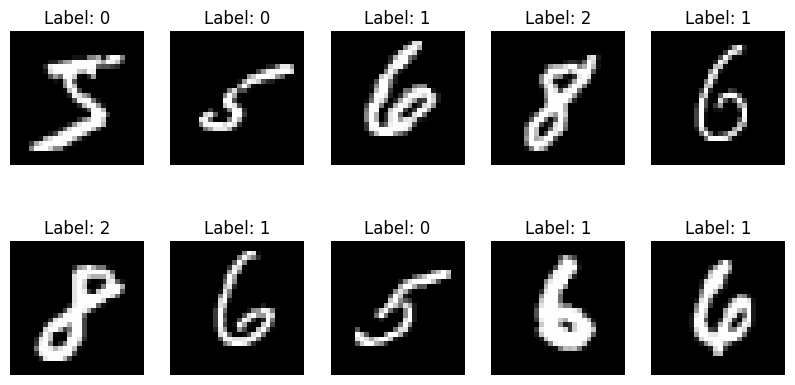

In [3]:
## Plot 6 to 10 images from your data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_nn[i], cmap='gray')
    plt.title(f'Label: {y_train_nn_bin[i]}')
    plt.axis('off')

plt.show()

# CNN with Pytorth

### Design the CNN Model

In [4]:
# Define a CNN model. 
# You are welcome to use the model from the fmnist_examples notebook, or you can try to create a better one.
# Either way, I recommend starting with the model from the fmnist_examples notebook and modifying it as you like.

# Important: Remember that our output has 3 classes, not 2 like in the Fashion MNIST dataset,
# So you will have to change at least one thing in the model to accommodate this.

import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Data Prep

In [5]:
# Convert your data to PyTorch tensors and create DataLoader objects for training and testing

# Convert the data to PyTorch tensors
x_train_tensor = torch.tensor(x_train_nn.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_nn_bin, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_nn.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_nn_bin, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Fit the CNN

In [6]:
# Initialize the model, loss function, and optimizer

t_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(t_model.parameters(), lr=0.001)

# Train the model
# More epochs takes more time, but also helps your model to be more accurate.
# Report some notion of accuracy, loss or both as it builds to see how well your model is doing.

num_epochs = 10
for epoch in range(num_epochs):
    t_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = t_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate validation loss and accuracy
    t_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_outputs = t_model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    # Compute metrics
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    
    # Print metrics rounded to 4 decimals
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')


# How does the test accuracy compare to that of the Random Forest model previously used?
print("The accuracy improved by about 0.01 compared to the Random Forest model.")


Epoch 1/10, Train Loss: 0.1162, Validation Loss: 0.0327, Validation Accuracy: 0.9919
Epoch 2/10, Train Loss: 0.0277, Validation Loss: 0.0168, Validation Accuracy: 0.9947
Epoch 3/10, Train Loss: 0.0181, Validation Loss: 0.0141, Validation Accuracy: 0.9947
Epoch 4/10, Train Loss: 0.0138, Validation Loss: 0.0182, Validation Accuracy: 0.9943
Epoch 5/10, Train Loss: 0.0106, Validation Loss: 0.0136, Validation Accuracy: 0.9965
Epoch 6/10, Train Loss: 0.0074, Validation Loss: 0.0150, Validation Accuracy: 0.9965
Epoch 7/10, Train Loss: 0.0050, Validation Loss: 0.0134, Validation Accuracy: 0.9972
Epoch 8/10, Train Loss: 0.0050, Validation Loss: 0.0131, Validation Accuracy: 0.9979
Epoch 9/10, Train Loss: 0.0034, Validation Loss: 0.0154, Validation Accuracy: 0.9954
Epoch 10/10, Train Loss: 0.0024, Validation Loss: 0.0143, Validation Accuracy: 0.9972
The accuracy improved by about 0.01 compared to the Random Forest model.


### Plot Confusion Matrix

[[891   1   0]
 [  3 952   3]
 [  1   0 973]]


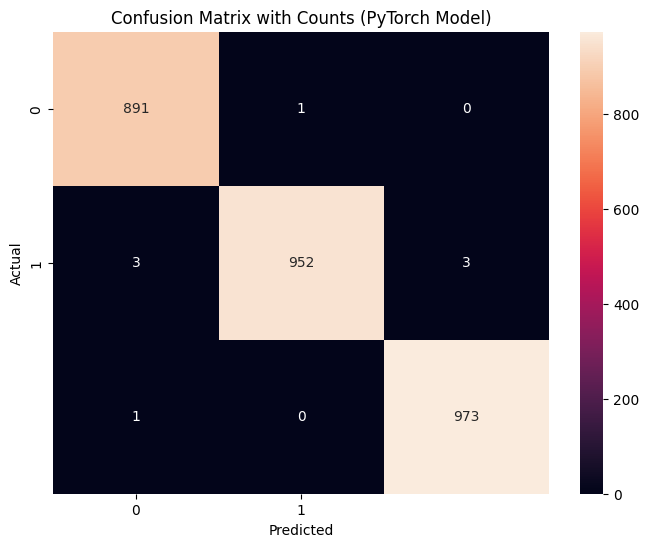

The model made very few misclassifications,
but struggled the most with correctly classifying 6's.


In [7]:
# Compute and plot a confusion matrix.

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
t_model.eval()
test_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = t_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.numpy())

# Convert predictions to numpy array
test_predictions = np.array(test_predictions)

# Compute the confusion matrix
conf_matrix_torch = confusion_matrix(y_test_nn_bin, test_predictions)

# Print the confusion matrix
print(conf_matrix_torch)

# Plot the confusion matrix with counts
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_torch, annot=True, fmt='d', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Counts (PyTorch Model)')
plt.show()

# Where are misclassifications occurring?
# How does your test accuracy compare to that of the Random Forest model previously made?
print("The model made very few misclassifications,")
print("but struggled the most with correctly classifying 6's.")

### Plot Misclassifications

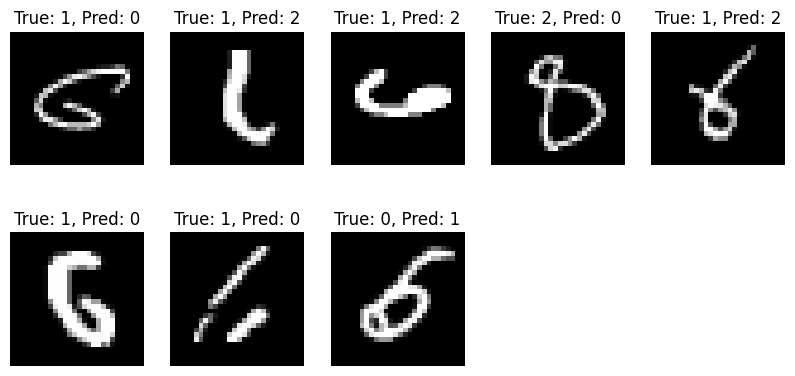

I can see why the model struggled to classify these numbers.
I would have misclassified a few of these too.


In [8]:
# Plot some of the misclassifications.

# Find the indices of misclassified samples
misclassified_indices_torch = [i for i in range(len(y_test_nn_bin)) if test_predictions[i] != y_test_nn_bin[i]]

plt.figure(figsize=(10, 10))

for i, idx in enumerate(misclassified_indices_torch[:]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_test_nn[idx], cmap='gray')
    plt.title(f'True: {y_test_nn_bin[idx]}, Pred: {test_predictions[idx]}')
    plt.axis('off')

plt.show()

# Can you see why the model made the misclassifications it did?
print("I can see why the model struggled to classify these numbers.")
print("I would have misclassified a few of these too.")

# CNN with Transformations

### Data Transformations

torch.Size([64, 1, 28, 28]) torch.Size([64])


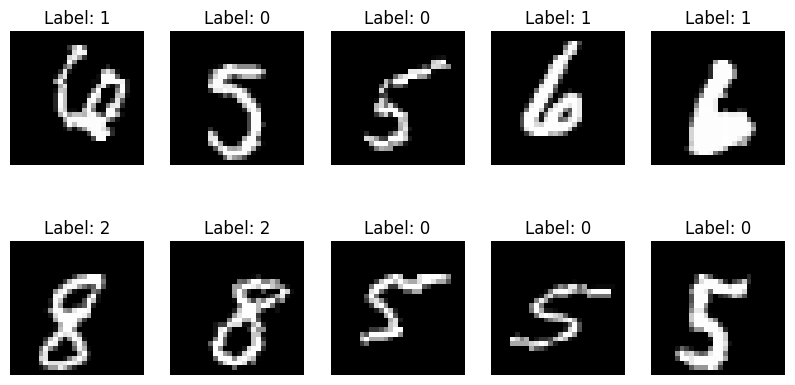

In [9]:
# Implement some kind of Appropriate Data Transformation(s) for this data set.
# You can/should copy the train_mod function from the fmnist_examples_ml2 notebook, but you will have to 
# think about whether all of the transformations are appropriate for this data set and maybe adjust them.

# There is 1 specific modification you must make to the train_mod function! Other modifications are great, but optional.

from torchvision.datasets import MNIST
from torchvision import transforms

# Define data augmentation transformations
train_mod = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),

    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))    # Normalize to [-1, 1]
])

test_mod = transforms.Compose([
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))       # Normalize to [-1, 1]
])

# Load the MNIST train dataset
train_dataset = MNIST(root="./data", train=True, transform=train_mod, download=True)

# Filter the dataset to only include the 3 classes of interest
# Convert to labels to 0, 1, 2
# Convert the dataset to a DataLoader object

train_indices = (train_dataset.targets == 5) | (train_dataset.targets == 6) | (train_dataset.targets == 8)
train_dataset.targets = train_dataset.targets[train_indices]
train_dataset.data = train_dataset.data[train_indices]

train_dataset.targets = [0 if y == 5 else (1 if y == 6 else 2) for y in train_dataset.targets]

train_loader_mod = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Repeat for the loading, filtering, and conversions on the test dataset
test_dataset = MNIST(root="./data", train=False, transform=test_mod, download=True)

test_indices = (test_dataset.targets == 5) | (test_dataset.targets == 6) | (test_dataset.targets == 8)
test_dataset.targets = test_dataset.targets[test_indices]
test_dataset.data = test_dataset.data[test_indices]

test_dataset.targets = [0 if y == 5 else (1 if y == 6 else 2) for y in test_dataset.targets]

test_loader_mod = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Plot some of the images in your train_loader. Check that your transformations provide
# a reasonable augmentation of the data. If they don't, adjust them in the train_mod function.

'Your code here'
# Iterate over batches
for images, labels in train_loader_mod:
    # images now contain dynamically augmented data
    print(images.shape, labels.shape)
    break  # Checking one batch

# Plot some of the transformed images
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')

plt.show()

### Fit the CNN

In [10]:
# Run your CNN using the data loaders containing different transformations.
# This very well may not be better than the model trained on the original data, 
# since we don't expect our test data to be transformed. But try it out.

# Provide initializations for a new model and train the model.
# Report some notion of accuracy, loss or both as it builds to see how well your model is doing.

'Your code here'
# Initialize the model, loss function, and optimizer
t_model3 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(t_model3.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    t_model3.train()
    running_loss = 0.0
    for inputs, labels in train_loader_mod:
        optimizer.zero_grad()
        outputs = t_model3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate validation loss and accuracy
    t_model3.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_inputs, val_labels in test_loader_mod:
            val_outputs = t_model3(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    # Compute metrics
    avg_train_loss = running_loss / len(train_loader_mod)
    avg_val_loss = val_loss / len(test_loader_mod)
    val_accuracy = correct / total
    
    # Print metrics rounded to 4 decimals
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

# How does the test accuracy compare to other models you've built?
print("The model performed slightly better (0.003) with the transformed images.")

Epoch 1/10, Train Loss: 0.1827, Validation Loss: 0.0393, Validation Accuracy: 0.9858
Epoch 2/10, Train Loss: 0.0768, Validation Loss: 0.0209, Validation Accuracy: 0.9933
Epoch 3/10, Train Loss: 0.0496, Validation Loss: 0.0174, Validation Accuracy: 0.9940
Epoch 4/10, Train Loss: 0.0388, Validation Loss: 0.0175, Validation Accuracy: 0.9954
Epoch 5/10, Train Loss: 0.0346, Validation Loss: 0.0116, Validation Accuracy: 0.9961
Epoch 6/10, Train Loss: 0.0290, Validation Loss: 0.0117, Validation Accuracy: 0.9965
Epoch 7/10, Train Loss: 0.0289, Validation Loss: 0.0112, Validation Accuracy: 0.9961
Epoch 8/10, Train Loss: 0.0252, Validation Loss: 0.0114, Validation Accuracy: 0.9958
Epoch 9/10, Train Loss: 0.0237, Validation Loss: 0.0075, Validation Accuracy: 0.9968
Epoch 10/10, Train Loss: 0.0193, Validation Loss: 0.0092, Validation Accuracy: 0.9965
The model performed slightly better (0.003) with the transformed images.
